In [1]:
# Mount colab to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import needed libraries

In [2]:
import os
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adamax

print ('modules loaded')

modules loaded


## Data Preprocessing

### Load data

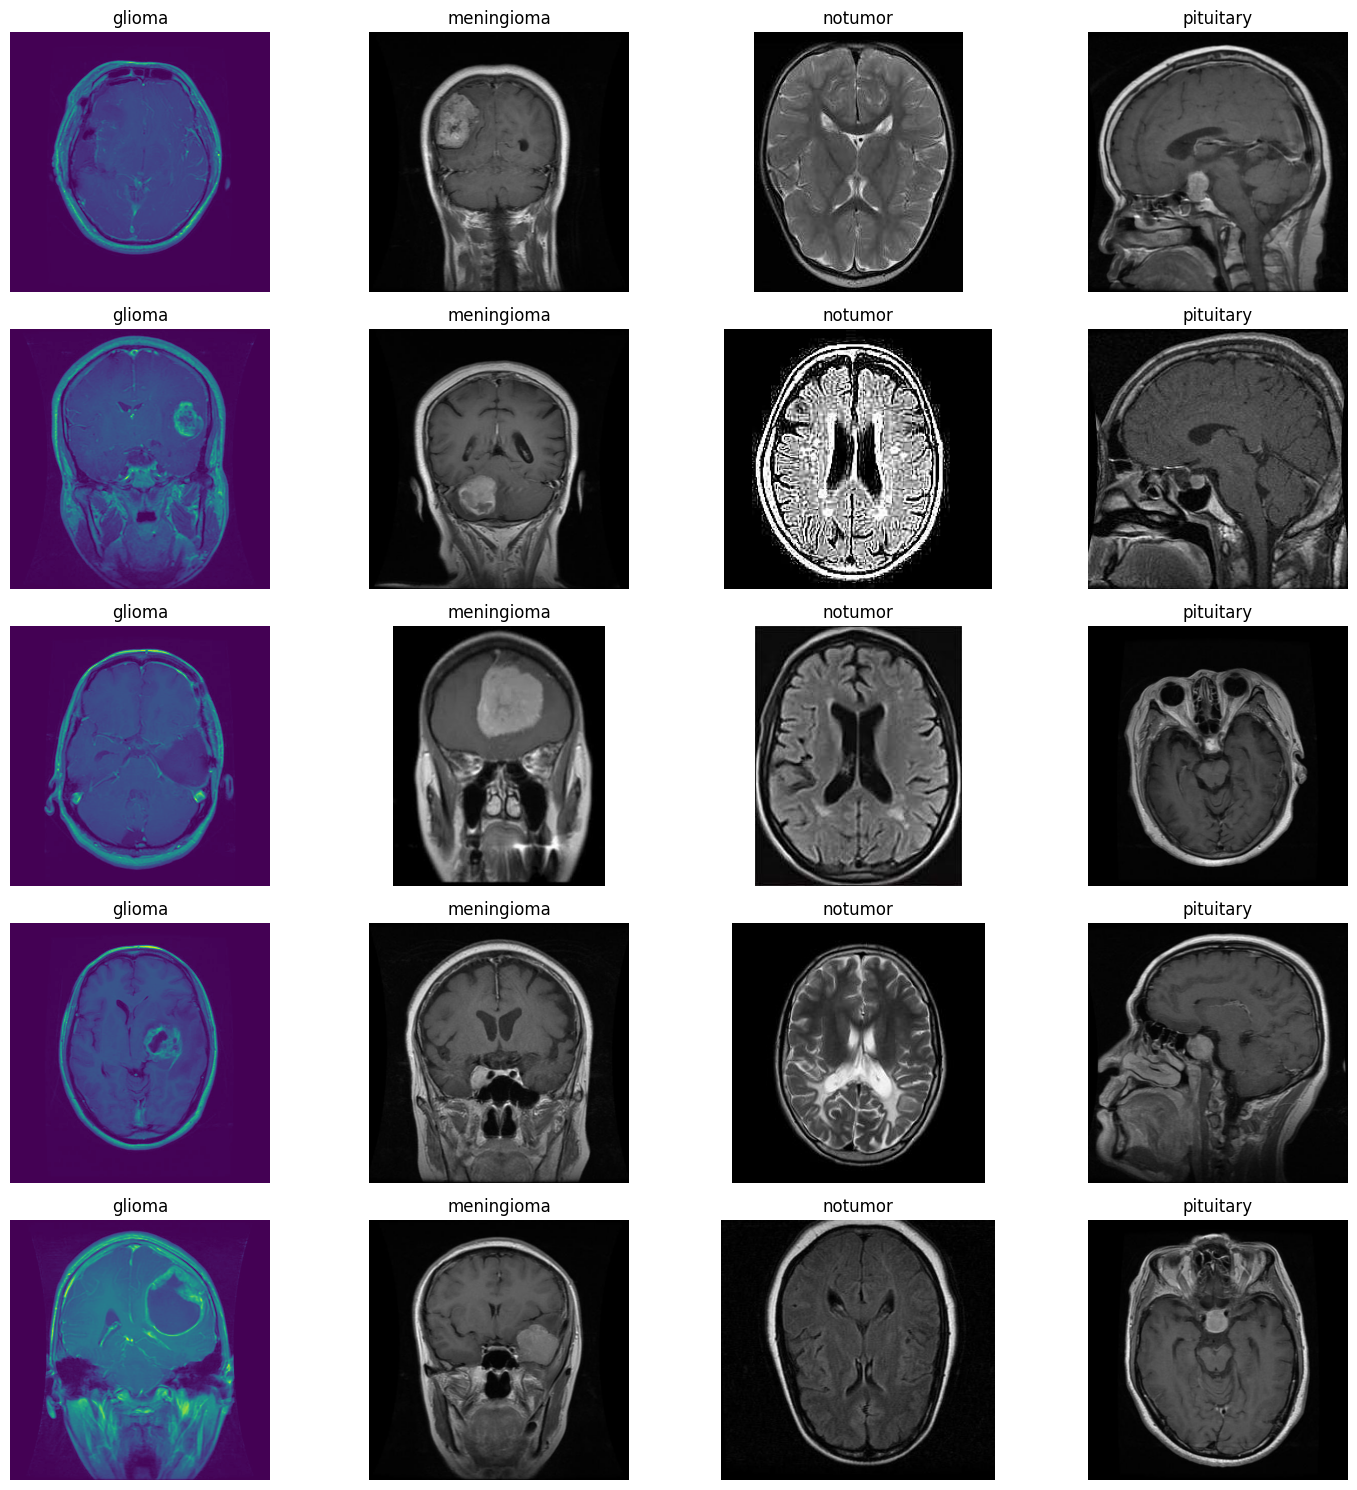

In [8]:
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

# Path to the directory containing the dataset
tr_df_path = "/content/drive/My Drive/BRAIN TUMER DATSET/Training"

# Lists to store labels and file paths
labels = []
filepaths = []

# Load 5 images for each class
for class_name in os.listdir(tr_df_path):
    class_dir = os.path.join(tr_df_path, class_name)
    count = 0
    for filename in os.listdir(class_dir):
        if count >= 5:  # Load only 5 images per class
            break
        filepath = os.path.join(class_dir, filename)
        if os.path.isfile(filepath) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            labels.append(class_name)
            filepaths.append(filepath)
            count += 1

# Create a DataFrame from the lists
tr_df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Display 5 images of each class
num_classes = len(tr_df['labels'].unique())
fig, axes = plt.subplots(5, num_classes, figsize=(15, 15))

for ax, (label, group) in zip(axes.T, tr_df.groupby('labels')):
    for i, (_, row) in enumerate(group.iterrows()):
        img = Image.open(row['filepaths'])
        ax[i].imshow(img)
        ax[i].set_title(label)
        ax[i].axis('off')

plt.tight_layout()
plt.show()


In [9]:
tr_df

,filepaths,labels
0,/content/drive/My Drive/BRAIN TUMER DATSET/Tra...,notumor
1,/content/drive/My Drive/BRAIN TUMER DATSET/Tra...,notumor
2,/content/drive/My Drive/BRAIN TUMER DATSET/Tra...,notumor
3,/content/drive/My Drive/BRAIN TUMER DATSET/Tra...,notumor
4,/content/drive/My Drive/BRAIN TUMER DATSET/Tra...,notumor
5,/content/drive/My Drive/BRAIN TUMER DATSET/Tra...,meningioma
6,/content/drive/My Drive/BRAIN TUMER DATSET/Tra...,meningioma
7,/content/drive/My Drive/BRAIN TUMER DATSET/Tra...,meningioma
8,/content/drive/My Drive/BRAIN TUMER DATSET/Tra...,meningioma
9,/content/drive/My Drive/BRAIN TUMER DATSET/Tra...,meningioma


In [10]:
tst_df_path="/content/drive/My Drive/BRAIN TUMER DATSET/Testing"
labels=[]
filepaths=[]

folds=os.listdir(tst_df_path)
for fold in folds:
    foldpath=os.path.join(tst_df_path,fold)
    foldlist=os.listdir(foldpath)
    for file in foldlist:
        filepath=os.path.join(foldpath,file)

        labels.append(fold)
        filepaths.append(filepath)

l=pd.Series(labels,name="labels")
f=pd.Series(filepaths,name="filepaths")

ts_df=pd.concat([f,l],axis=1)

In [ ]:
ts_df

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
...,...,...
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
1307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
1308,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
1309,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor


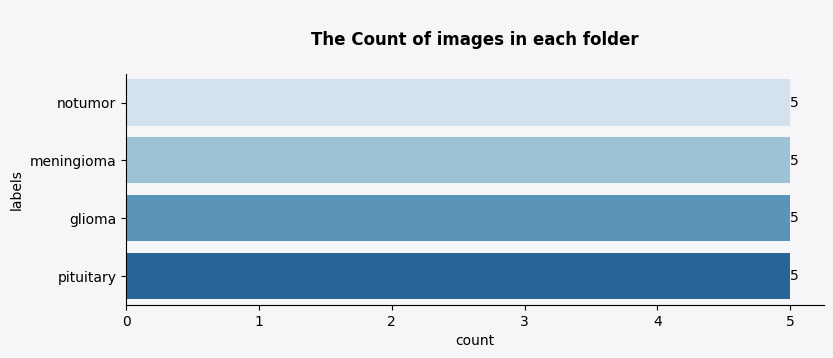

In [11]:
fig,ax=plt.subplots(figsize=(9,3))
fig.patch.set_facecolor("#f6f5f7")
ax.set_facecolor("#f6f5f7")
for i in ["top","right"]:
    ax.spines[i].set_visible(False)

x = sns.countplot(data=tr_df, y=tr_df["labels"],palette='Blues')
for container in x.containers:
    x.bar_label(container)
plt.title("\nThe Count of images in each folder\n",weight="bold");

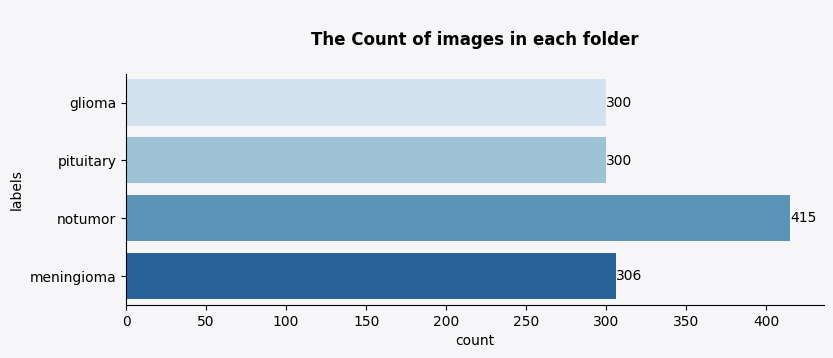

In [12]:
fig,ax=plt.subplots(figsize=(9,3))
fig.patch.set_facecolor("#f6f5f7")
ax.set_facecolor("#f6f5f7")
for i in ["right","top"]:
    ax.spines[i].set_visible(False)

i=sns.countplot(data=ts_df,y=ts_df["labels"],palette='Blues')
for container in i.containers:
    i.bar_label(container)

plt.title("\nThe Count of images in each folder\n",weight="bold");

In [13]:
ts_df.shape

(1321, 2)

### Split dataframe into train, valid, and test

In [14]:
valid_df,tst_df=train_test_split(ts_df,test_size=0.5,random_state=50,stratify=ts_df["labels"])
print(f"ts_df shape: {ts_df.shape}")
print("---"*10)
print(f"valid data shape: {valid_df.shape}")
print(f"test data shape: {tst_df.shape}")

ts_df shape: (1321, 2)
------------------------------
valid data shape: (660, 2)
test data shape: (661, 2)


In [15]:
valid_df

,filepaths,labels
778,/content/drive/My Drive/BRAIN TUMER DATSET/Tes...,notumor
783,/content/drive/My Drive/BRAIN TUMER DATSET/Tes...,notumor
698,/content/drive/My Drive/BRAIN TUMER DATSET/Tes...,notumor
1154,/content/drive/My Drive/BRAIN TUMER DATSET/Tes...,meningioma
1126,/content/drive/My Drive/BRAIN TUMER DATSET/Tes...,meningioma
...,...,...
176,/content/drive/My Drive/BRAIN TUMER DATSET/Tes...,glioma
902,/content/drive/My Drive/BRAIN TUMER DATSET/Tes...,notumor
807,/content/drive/My Drive/BRAIN TUMER DATSET/Tes...,notumor
1,/content/drive/My Drive/BRAIN TUMER DATSET/Tes...,glioma


### Create image data generator

In [16]:
img_size=(224,224)

tr=ImageDataGenerator()
ts=ImageDataGenerator()

train_gen=tr.flow_from_dataframe(tr_df,x_col="filepaths",y_col="labels",
                                 target_size=img_size,
                                 batch_size=16,shuffle=True,
                                 class_mode='categorical',color_mode="rgb")


valid_gen=ts.flow_from_dataframe(ts_df,x_col='filepaths',y_col='labels',
                                target_size=img_size,
                                 class_mode="categorical",color_mode="rgb",
                                 shuffle=True,batch_size=16,)


test_gen=ts.flow_from_dataframe(ts_df, x_col='filepaths', y_col='labels',
                                 target_size=img_size,
                                 batch_size=16, shuffle=False,
                                 color_mode="rgb", class_mode="categorical")

Found 20 validated image filenames belonging to 4 classes.
Found 1321 validated image filenames belonging to 4 classes.
Found 1321 validated image filenames belonging to 4 classes.


### Show sample from train data

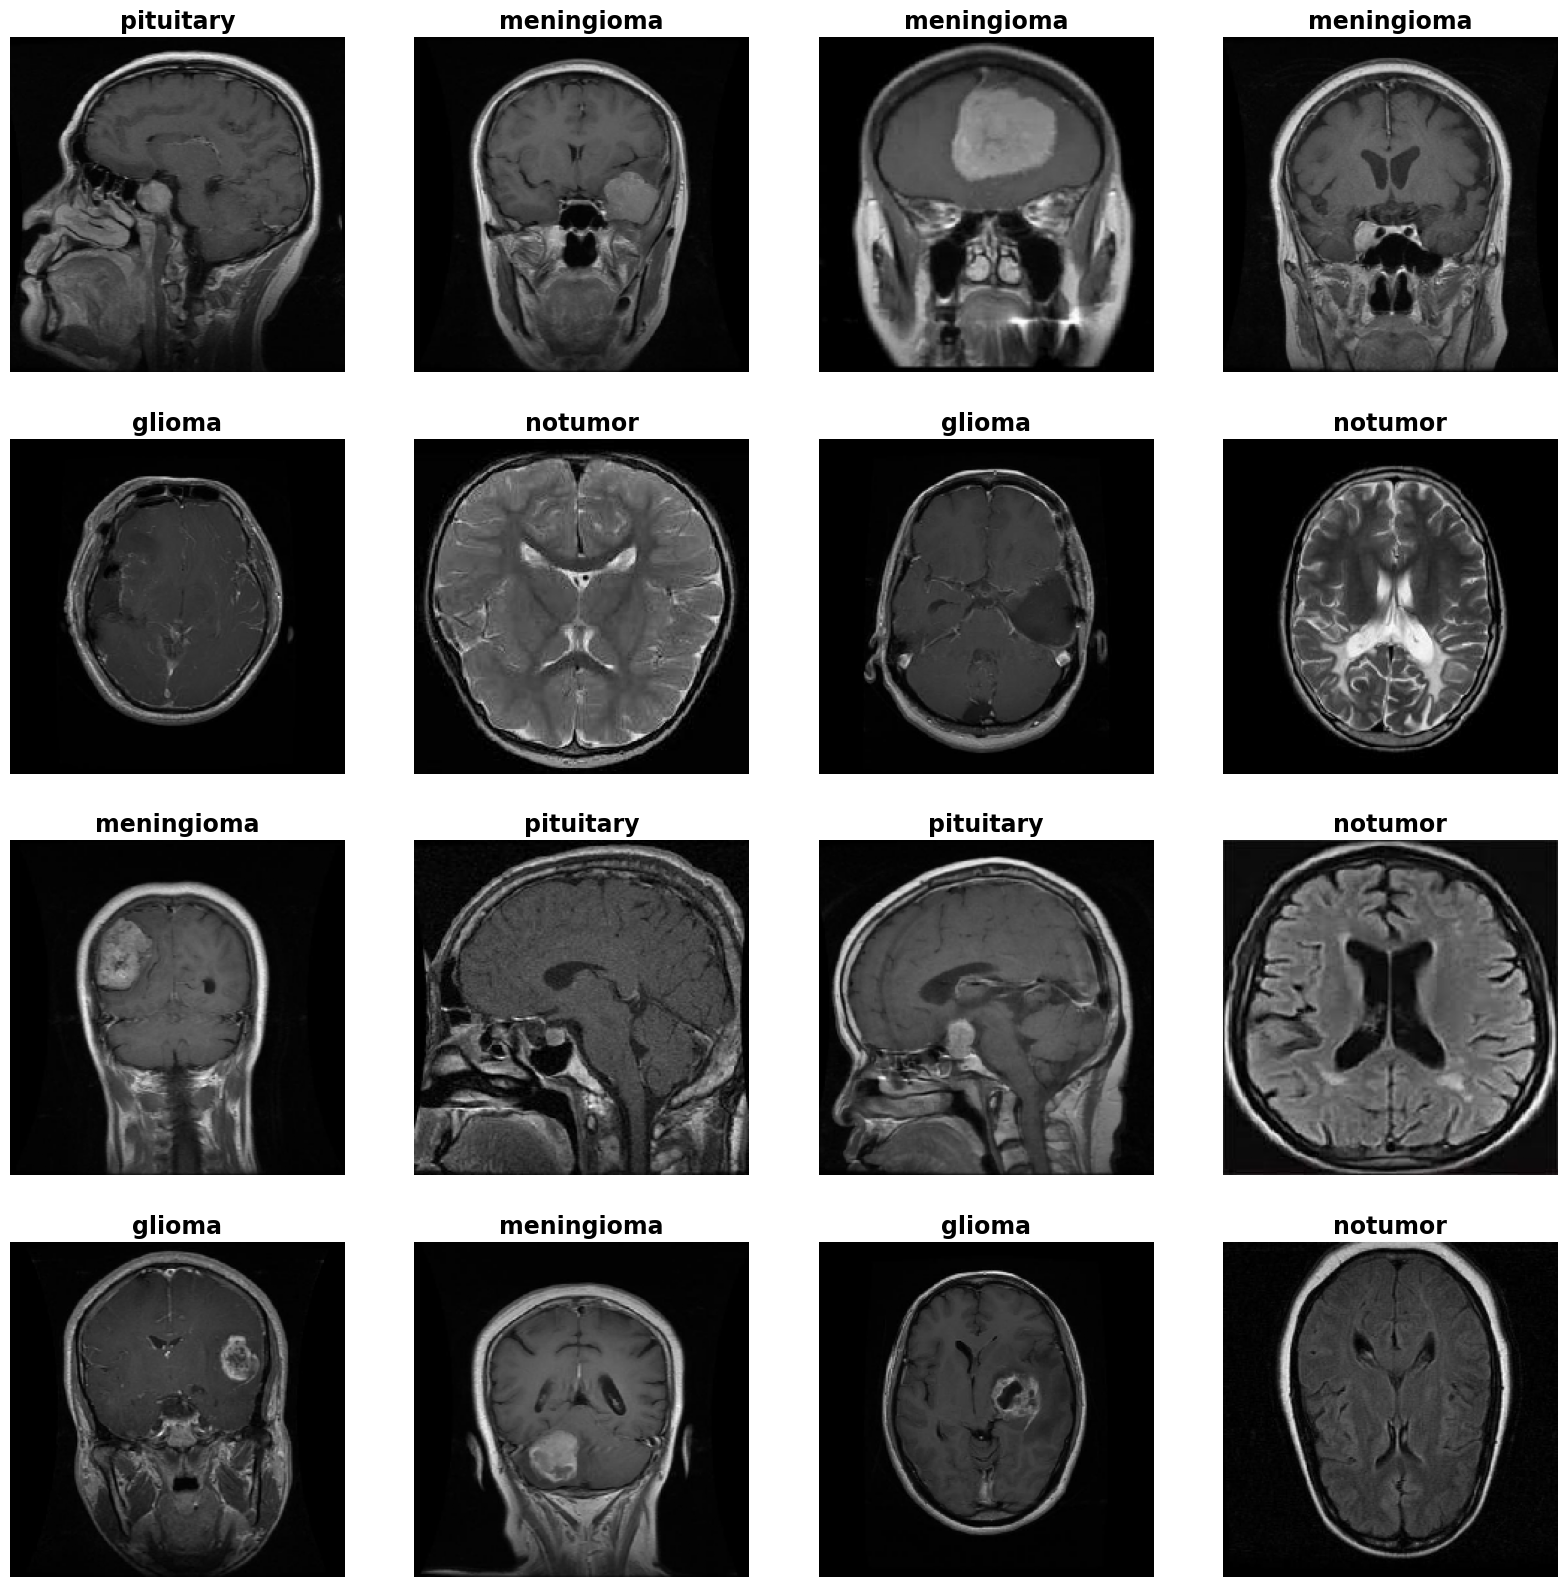

In [17]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'black' , fontsize= 17,weight="bold")
    plt.axis('off')
plt.show()

##  Building Deep Learning Model

In [18]:
img_shape=(224,224,3)
base_Model = tf.keras.applications.Xception(include_top= False,weights= "imagenet",
                                            input_shape= img_shape, pooling= 'max')

Model = Sequential([
    base_Model,
    Dropout(rate= 0.5),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

Model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy'])

Model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 21124268 (80.58 MB)
Trainable params: 21069740 (80.37 MB)
Non-trainable params: 54528 (213.00 KB)
___________

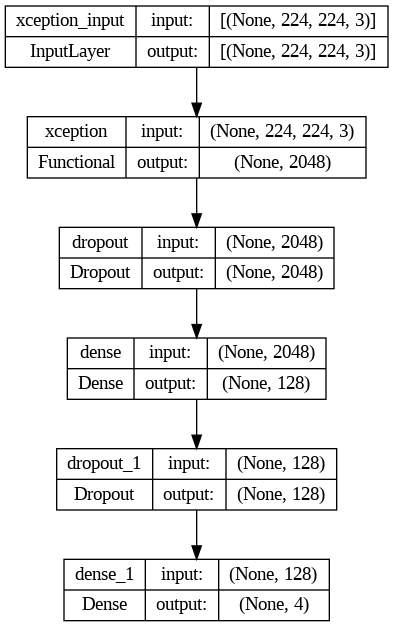

In [19]:
tf.keras.utils.plot_model(Model,show_shapes=True)

##  Training

In [20]:
historyy=Model.fit(train_gen,epochs=10,
                  validation_data=valid_gen,
                  shuffle=False)

Epoch 1/10
2/2 [==============================] - 381s 350s/step - loss: 3.9732 - accuracy: 0.1000 - val_loss: 3.7715 - val_accuracy: 0.2150
Epoch 2/10
2/2 [==============================] - 7s 7s/step - loss: 1.3999 - accuracy: 0.3000 - val_loss: 2.7408 - val_accuracy: 0.2279
Epoch 3/10
2/2 [==============================] - 11s 10s/step - loss: 1.2660 - accuracy: 0.3500 - val_loss: 1.9827 - val_accuracy: 0.2279
Epoch 4/10
2/2 [==============================] - 7s 6s/step - loss: 1.1802 - accuracy: 0.7000 - val_loss: 1.6233 - val_accuracy: 0.2339
Epoch 5/10
2/2 [==============================] - 7s 6s/step - loss: 1.0694 - accuracy: 0.7500 - val_loss: 1.4756 - val_accuracy: 0.2528
Epoch 6/10
2/2 [==============================] - 7s 7s/step - loss: 0.8522 - accuracy: 0.9500 - val_loss: 1.4013 - val_accuracy: 0.2990
Epoch 7/10
2/2 [==============================] - 11s 10s/step - loss: 0.7450 - accuracy: 0.8000 - val_loss: 1.3665 - val_accuracy: 0.3512
Epoch 8/10
2/2 [=================

### Visualize model performance

In [ ]:
model_json = Model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
Model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
historyy.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

<Figure size 2000x800 with 0 Axes>

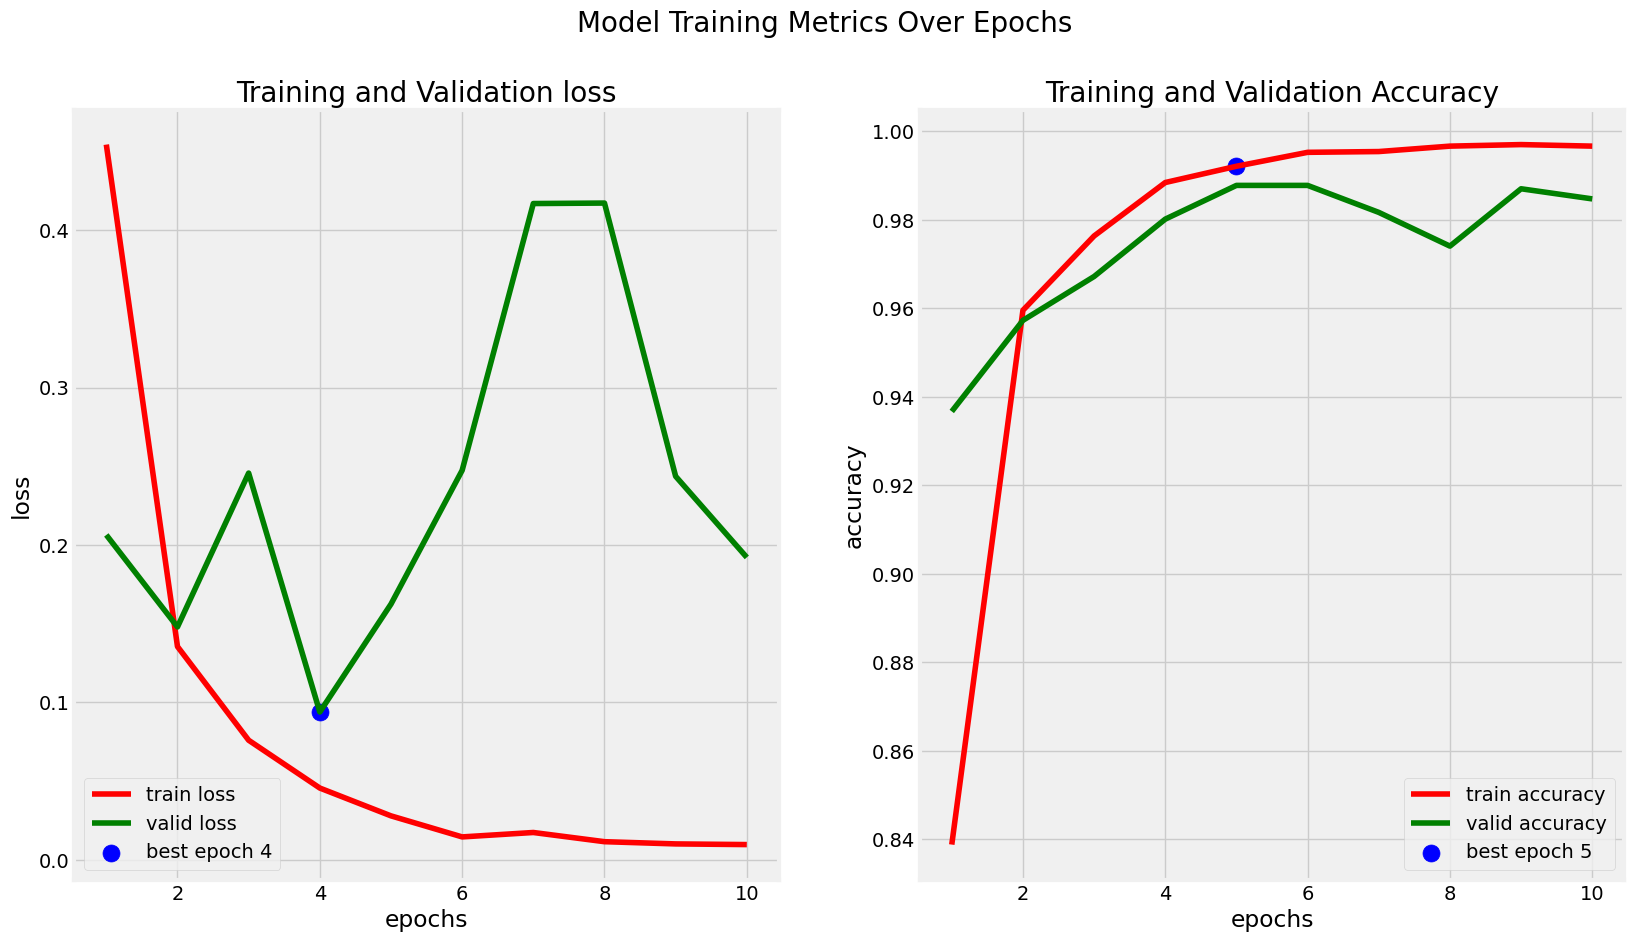

In [ ]:
plt.figure(figsize=(20, 8))
tr_loss=historyy.history["loss"]
val_loss=historyy.history["val_loss"]
index_loss=np.argmin(val_loss)
loss_lowest=val_loss[index_loss]
l_label=f"best epoch {index_loss+1}"

tr_accuracy=historyy.history["accuracy"]
val_accuracy=historyy.history["val_accuracy"]
index_acc=np.argmax(val_accuracy)
acc_highest=tr_accuracy[index_acc]
c_label=f"best epoch {index_acc+1}"

epochs=[i+1 for i in range (len(tr_accuracy))]


plt.figure(figsize=(20,10))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(epochs,tr_loss,"r",label="train loss")
plt.plot(epochs,val_loss,"g",label="valid loss")
plt.scatter(index_loss+1,loss_lowest,c="b",s=150,label=l_label)
plt.title('Training and Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs,tr_accuracy,"r",label="train accuracy")
plt.plot(epochs,val_accuracy,"g",label="valid accuracy")
plt.scatter(index_acc+1,acc_highest,c="b",s=150,label=c_label)
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()


plt.suptitle('Model Training Metrics Over Epochs', fontsize=20);

##  Evaluate model

In [ ]:
train_score=Model.evaluate(train_gen)
valid_score=Model.evaluate(valid_gen)
test_score=Model.evaluate(test_gen)

print(f"Train Loss : {train_score[0]:.3f}")
print(f"Train Accuracy : {train_score[1]*100:.2f}%")
print("-"*20)
print(f"Validation Loss : {valid_score[0]:.3f}")
print(f"Validation Accuracy : {valid_score[1]*100:.2f}%")
print("-"*20)
print(f"Test Loss: {test_score[0]:.3f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

82/82 [==============================] - 6s 69ms/step - loss: 0.1921 - accuracy: 0.9847
Train Loss : 0.048
Train Accuracy : 99.61%
--------------------
Validation Loss : 0.192
Validation Accuracy : 98.47%
--------------------
Test Loss: 0.192
Test Accuracy: 98.47%


## Get Predictions

In [ ]:
preds=Model.predict(test_gen)
y_pred=np.argmax(preds,axis=1)

82/82 [==============================] - 6s 66ms/step


### Confusion Matrics and Classification Report

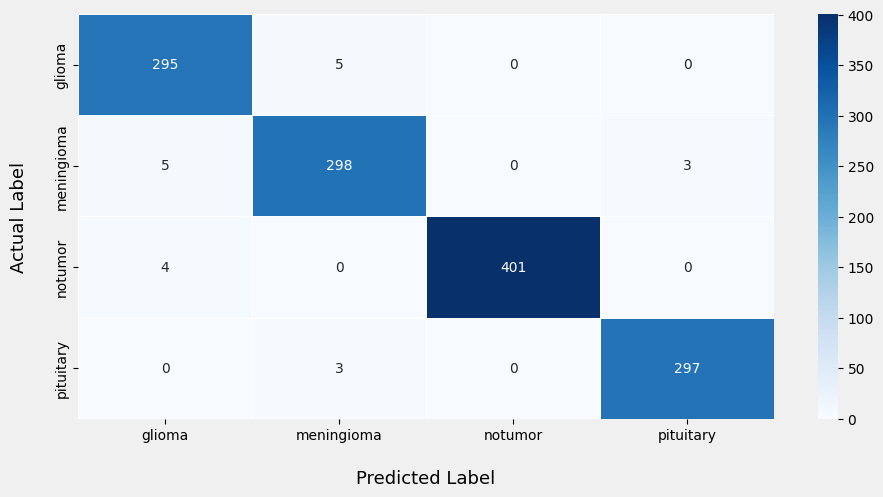

In [ ]:
plt.figure(figsize=(10,5))
plt.style.use('default')
cm=confusion_matrix(test_gen.classes,y_pred)
labels = list(test_gen.class_indices.keys())
sns.heatmap(cm,annot=True,fmt="d",xticklabels=labels,yticklabels=labels,cmap="Blues", linewidths=.5)
plt.xlabel('\nPredicted Label',fontsize=13)
plt.ylabel('Actual Label\n',fontsize=13);

In [ ]:
cr=classification_report(test_gen.classes,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       300
           1       0.97      0.97      0.97       306
           2       1.00      0.99      1.00       405
           3       0.99      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311

